# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [7]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time
import heapq
%matplotlib inline

/tmp/ipykernel_4920/187924686.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_4920/187924686.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


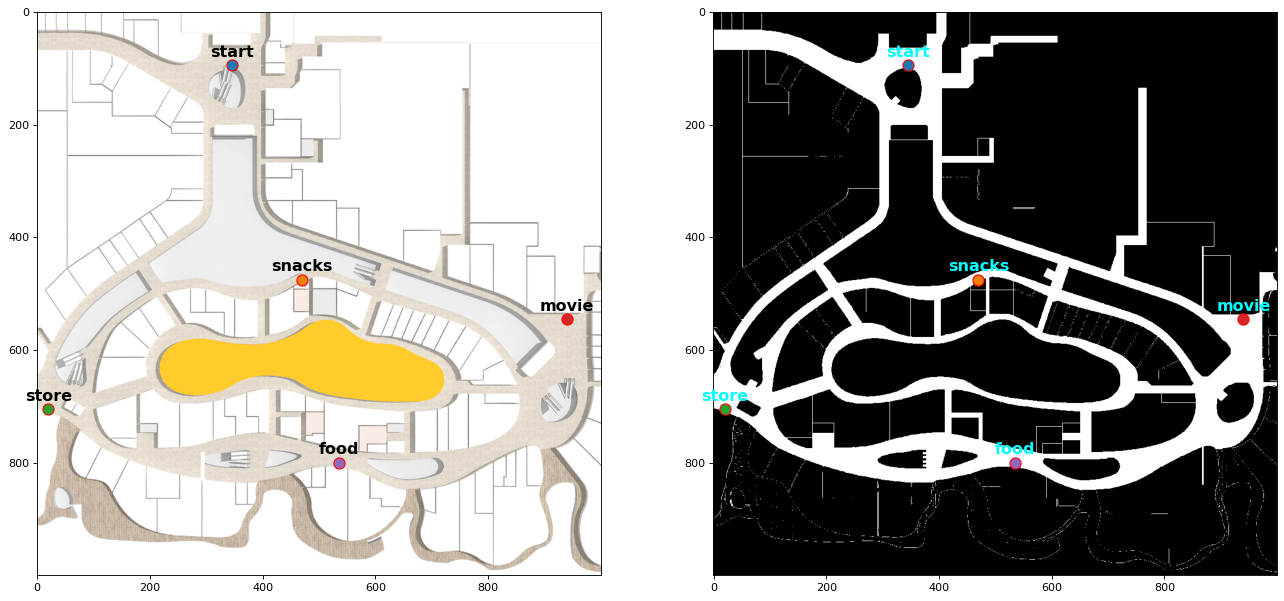

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [8]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

Implement A*

## Task 1

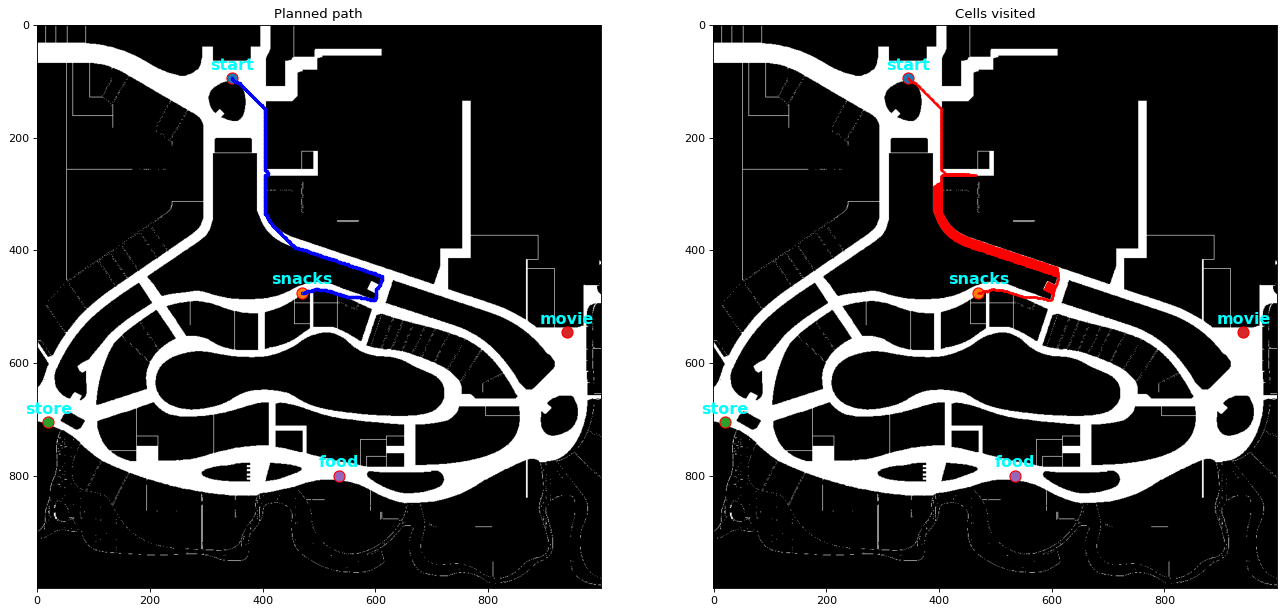

The total travelled distance in meters: 143.702
The number of the cells visited by your algorithm: 20214
The total run time of your algorithm: 0.5670628547668457


In [9]:
# Define the heuristic function
#1. Euclidean distance
def h(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

#2. Manhattan distance
# def h(a, b):
#     (x1, y1) = a
#     (x2, y2) = b
#     return abs(x1 - x2) + abs(y1 - y2)

#3. Chebyshev distance
# def h(a, b):
#     (x1, y1) = a
#     (x2, y2) = b
#     return max(abs(x1 - x2), abs(y1 - y2))

# Define the cost function
def cost(a, b):
    (x1, y1) = a
    (x2, y2) = b
    if x1 == x2 or y1 == y2:
        return 0.2
    else:
        return 0.282


def get_neighbour(node, map_data, labeled_map):
    dirs = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    result = []
    for dir in dirs:
        neighbor = (node[0] + dir[0], node[1] + dir[1])
        if labeled_map[neighbor[0], neighbor[1]] == 0:          # 0 means have obstacle nearby
            continue
        elif labeled_map[neighbor[0], neighbor[1]] == 1:
            result.append(neighbor)                             # 1 means have been checked no obstacle nearby
            continue
    
        if 0 <= neighbor[0] < map_data.shape[0] and 0 <= neighbor[1] < map_data.shape[1] and map_data[neighbor[0], neighbor[1]] == 255:
            
            # Check if all 8-connected neighbors of the neighbor are reachable
            all_neighbors_reachable = True
            for dir2 in dirs:
                neighbor2 = (neighbor[0] + dir2[0], neighbor[1] + dir2[1])
                if not (0 <= neighbor2[0] < map_data.shape[0] and 0 <= neighbor2[1] < map_data.shape[1] and map_data[neighbor2[0], neighbor2[1]] == 255):
                    all_neighbors_reachable = False
                    labeled_map[neighbor[0], neighbor[1]] = 0   # 0 means have obstacle nearby
                    break
                    
            if all_neighbors_reachable:
                result.append(neighbor)
                labeled_map[neighbor[0], neighbor[1]] = 1       # 1 means have been checked no obstacle nearby
                
    return result

# Define the function to reconstruct the path
def reconstruct_path(came_from, current):
    path = []
    while current in came_from:
        path.append(current)
        current = came_from[current]
    path.append(current)
    path.reverse()
    return path

def plot_path(path, visited_set, locations, grid_map_img):
    plt.figure(figsize=(20, 10), dpi=80)
    
    # Left subplot for planned path
    plt.subplot(1,2,1)
    plt.title('Planned path')
    plt.imshow(grid_map_img, cmap='gray')
    plot_locations(locations, color='cyan')
    for node in path:
        plt.plot(node[0], node[1], marker="o", markersize=2, markeredgecolor="blue")
    
    # Right subplot for visited cells
    plt.subplot(1,2,2)
    plt.title('Cells visited')
    plt.imshow(grid_map_img, cmap='gray')
    plot_locations(locations, color='cyan')
    for node in visited_set:
        plt.plot(node[0], node[1], marker="o", markersize=1, markeredgecolor="red")
    
    plt.show()


def a_star(start, goal, map_data):
    start_time = time.time()
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: h(start, goal)}
    visited_nodes = 0
    obstacle_map = grid_map.copy()
    visited_set = set()

    while open_set:
        current = heapq.heappop(open_set)[1]
        visited_nodes += 1
        visited_set.add(current)

        if current == goal:
            path = reconstruct_path(came_from, current)
            return path, visited_set, g_score[current], visited_nodes, time.time() - start_time

        for neighbor in get_neighbour(current, map_data, obstacle_map):
            tentative_g_score = g_score[current] + cost(current, neighbor)
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + h(neighbor, goal)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None

# Run the A* algorithm
start = tuple(locations['start'])
goal = tuple(locations['snacks'])
path, visited_set, distance, visited_nodes, run_time = a_star(start, goal, grid_map)

plot_path(path, visited_set, locations, grid_map_img)
# Print the results
print("The total travelled distance in meters:", round(distance,3))
print("The number of the cells visited by your algorithm:", visited_nodes)
print("The total run time of your algorithm:", run_time)

Adjacency matrix  A* output

In [10]:
matrix = np.zeros((len(locations), len(locations)))

# Use two for loops to calculate the distance between each pair of locations
for i, location1 in enumerate(locations.values()):
    for j, location2 in enumerate(locations.values()):
        # Use the A* algorithm to calculate the distance
        if i == j:
            continue
        _,_, distance, _, _ = a_star(tuple(location1), tuple(location2), grid_map)
        matrix[i, j] = distance

print(matrix)

[[  0.    143.702 163.504 180.832 231.976]
 [154.306   0.    122.892 125.208 133.934]
 [166.626 117.01    0.    255.17  114.732]
 [182.8   108.962 239.162   0.    200.294]
 [235.742 133.442 122.912 118.      0.   ]]


Implement Greedy Best First Search Algorithm

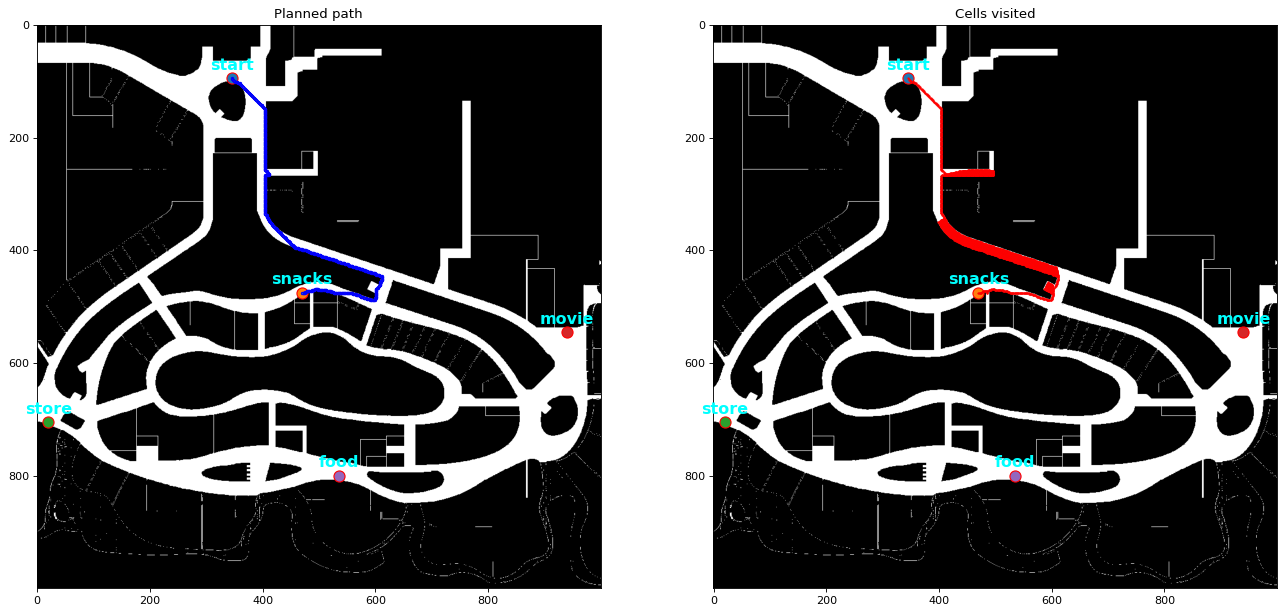

The total travelled distance in meters: 144.384
The number of the cells visited by your algorithm: 21825
The total run time of your algorithm: 0.5551350116729736


In [11]:
def gbfs(start, goal, map_data):
    start_time = time.time()
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: h(start, goal)}
    visited_nodes = 0
    obstacle_map = grid_map.copy()
    visited_set = set()

    while open_set:
        current = heapq.heappop(open_set)[1]
        visited_nodes += 1
        visited_set.add(current)

        if current == goal:
            path = reconstruct_path(came_from, current)
            return path,visited_set, g_score[current], visited_nodes, time.time() - start_time

        for neighbor in get_neighbour(current, map_data, obstacle_map):
            tentative_g_score = g_score[current] + cost(current, neighbor)
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = h(neighbor, goal)  # Only use heuristic function h(n) for GBFS
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None

# Run the GBFS algorithm
start = tuple(locations['start'])
goal = tuple(locations['snacks'])
path, visited_set, distance, visited_nodes, run_time = gbfs(start, goal, grid_map)

# Plot the path
plot_path(path, visited_set, locations, grid_map_img)

# Print the results
print("The total travelled distance in meters:", round(distance,3))
print("The number of the cells visited by your algorithm:", visited_nodes)
print("The total run time of your algorithm:", run_time)

 Implement Dijkstra

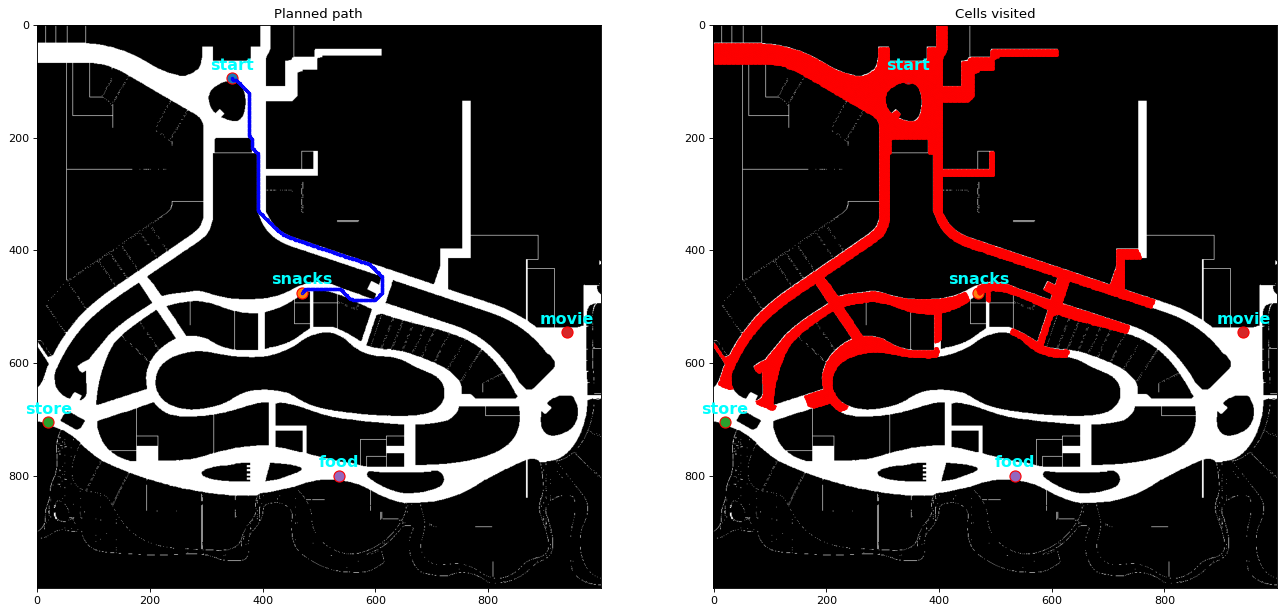

The total travelled distance in meters: 142.318
The number of the cells visited by your algorithm: 78938
The total run time of your algorithm: 2.5891759395599365


In [12]:
# Define the Dijkstra algorithm
def dijkstra(start, goal,map_data):
    start_time = time.time()
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    visited_nodes = 0
    obstacle_map = grid_map.copy()
    visited_set = set()

    while open_set:
        current = heapq.heappop(open_set)[1]
        visited_nodes += 1
        visited_set.add(current)

        if current == goal:
            path = reconstruct_path(came_from, current)
            return path, visited_set,g_score[current], visited_nodes, time.time() - start_time

        for neighbor in get_neighbour(current,map_data,obstacle_map):
            tentative_g_score = g_score[current] + cost(current, neighbor)
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                heapq.heappush(open_set, (tentative_g_score, neighbor))

    return None

# Run the Dijkstra algorithm
start = tuple(locations['start'])
goal = tuple(locations['snacks'])
path, visited_set, distance, visited_nodes, run_time = dijkstra(start, goal,grid_map)

# Plot the path
plot_path(path, visited_set, locations, grid_map_img)

# Print the results
print("The total travelled distance in meters:", round(distance,3))
print("The number of the cells visited by your algorithm:", visited_nodes)
print("The total run time of your algorithm:", run_time)

Adjacency matrix  Dijkstra output

In [13]:
matrix = np.zeros((len(locations), len(locations)))

# Use two nested loops to calculate the distance between each pair of points
for i, location1 in enumerate(locations.values()):
    for j, location2 in enumerate(locations.values()):
        # Use Dijkstra algorithm to calculate the shortest distance between two points
        if i == j:
            continue
        _,_, distance, _, _ = dijkstra(tuple(location1), tuple(location2),grid_map)
        matrix[i, j] = distance

print(matrix)

[[  0.    142.318 154.904 178.674 223.05 ]
 [142.318   0.    114.642 107.382 133.278]
 [154.904 114.642   0.    209.246 110.79 ]
 [178.674 107.382 209.246   0.    113.592]
 [223.05  133.278 110.79  113.592   0.   ]]


## Task 2

In [17]:
import networkx as nx

# Create a complete graph
graph = nx.complete_graph(locations.keys())

distance_array = [142.318, 154.904, 178.674, 223.05, \
                  114.642, 107.382, 133.278, \
                  209.246, 110.79, \
                  113.592]
# Use the distance array from Dij to update the weights of the edges
for counter, (u, v) in enumerate(graph.edges()):
    graph[u][v]['weight'] = distance_array[counter]

# Print the nodes and the adjacency matrix
print("Nodes in the graph:", graph.nodes())
print("Adjacency Matrix:")
print(nx.to_numpy_array(graph, weight='weight'))

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# Start time
start_time = time.time()

# node_index is a dictionary that maps the node name to its index in the list of nodes
nodes = list(graph.nodes())
n = len(nodes)
node_index = {node: i for i, node in enumerate(nodes)}

# initialize the shortest_path_cost and parent arrays
shortest_path_cost = np.full((1 << n, n), np.inf)
parent = np.full((1 << n, n), -1)
shortest_path_cost[1][0] = 0  # Assume that the starting node is the first node

# Dynamic programming process
for mask in range(1, 1 << n):
    for u in range(n):
        if not (mask & (1 << u)):
            continue
        for v in range(n):
            if mask & (1 << v) and v != u:
                prev_mask = mask ^ (1 << u)
                if shortest_path_cost[prev_mask][v] + graph[nodes[v]][nodes[u]]['weight'] < shortest_path_cost[mask][u]:
                    shortest_path_cost[mask][u] = shortest_path_cost[prev_mask][v] + graph[nodes[v]][nodes[u]]['weight']
                    parent[mask][u] = v

# Rebuid the path
mask = (1 << n) - 1
u = np.argmin(shortest_path_cost[-1])
sequence = [u]

while u != -1:
    v = parent[mask][u]
    if v != -1:
        sequence.append(v)
    mask = mask ^ (1 << u)
    u = v

sequence = sequence[::-1]  # Reverse the sequence to get the correct order
path = [nodes[i] for i in sequence]  # Convert the sequence of indices to the sequence of nodes

# Calculate the total distance
total_distance = sum(graph[path[i]][path[i+1]]['weight'] for i in range(n-1)) + graph[path[-1]][path[0]]['weight']

# End time
end_time = time.time()

# Output the results
path.append(path[0])  # Add the starting node to the end of the path
print("Visit order:", path)
print("Total Travelled Distance:", round(total_distance, 3), "m")
print("Total Run Time:", round(end_time - start_time, 3), "seconds")


Visit order: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total Travelled Distance: 628.986 m
Total Run Time: 0.001 seconds
